### Building Knowledge Graph From Text

**Important Links**

https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

https://cacm.acm.org/magazines/2019/8/238342-industry-scale-knowledge-graphs/fulltext?mobile=false

In [5]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load(en_core_web_sm)

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [6]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [7]:
candidate_sentences.head()

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


In [28]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
    print(tok.text, "...", tok.dep_) # dependency parsing
    print("-----"*5)
    print(tok.text, "-->", tok.pos_) # POS tagging

the ... det
-------------------------
the --> DET
drawdown ... amod
-------------------------
drawdown --> ADJ
process ... nsubjpass
-------------------------
process --> NOUN
is ... auxpass
-------------------------
is --> AUX
governed ... ROOT
-------------------------
governed --> VERB
by ... agent
-------------------------
by --> ADP
astm ... compound
-------------------------
astm --> NOUN
standard ... amod
-------------------------
standard --> NOUN
d823 ... pobj
-------------------------
d823 --> NOUN


### Entity Pairs Extraction


The main idea is to go through a sentence and extract the subject and the object as and when they are encountered.

In [11]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
            prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

#### Let me explain the code chunks in the function above:

##### Chunk 1

I have defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

##### Chunk 2

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

##### Chunk 3

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

##### Chunk 4

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

##### Chunk 5

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

In [12]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [13]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:26<00:00, 50.19it/s]


In [14]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'telepath selene gallio'],
 ['singer', 'sequel']]

### Relation / Predicate Extraction

This is going to be a very interesting aspect of this article. Our hypothesis is that the predicate is actually the main verb in a sentence.

For example, in the sentence – “*Sixty Hollywood musicals were released in 1929*”, the verb is “*released in*” and this is what we are going to use as the predicate for the triple generated from this sentence.

In [15]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [16]:
get_relation("John completed the task")

'completed'

In [17]:
# Similarly, let’s get the relations from all the Wikipedia sentences:

relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:06<00:00, 65.08it/s]


In [18]:
pd.Series(relations).value_counts()[:20]

is             372
was            302
released on     88
are             74
include         72
were            67
released        42
's              39
composed by     35
became          31
have            31
has             30
become          28
released in     27
included        25
had             21
called          21
made            20
considered      20
produced        19
dtype: int64

### Build a Knowledge Graph
We will finally create a **knowledge graph** from the extracted entities (subject-object pairs) and the predicates (relation between entities).

##### Let’s create a dataframe of entities and predicates:

In [19]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [20]:
kg_df.head()

,source,target,edge
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with


Next, we will use the networkx library to create a network from this dataframe. **The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes**.

It is going to be a **directed graph**. In other words, the relation between any connected node pair is not two-way, it is only from one node to another. For example, “John eats pasta”:

In [21]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

C:\Users\Supratik\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Supratik\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


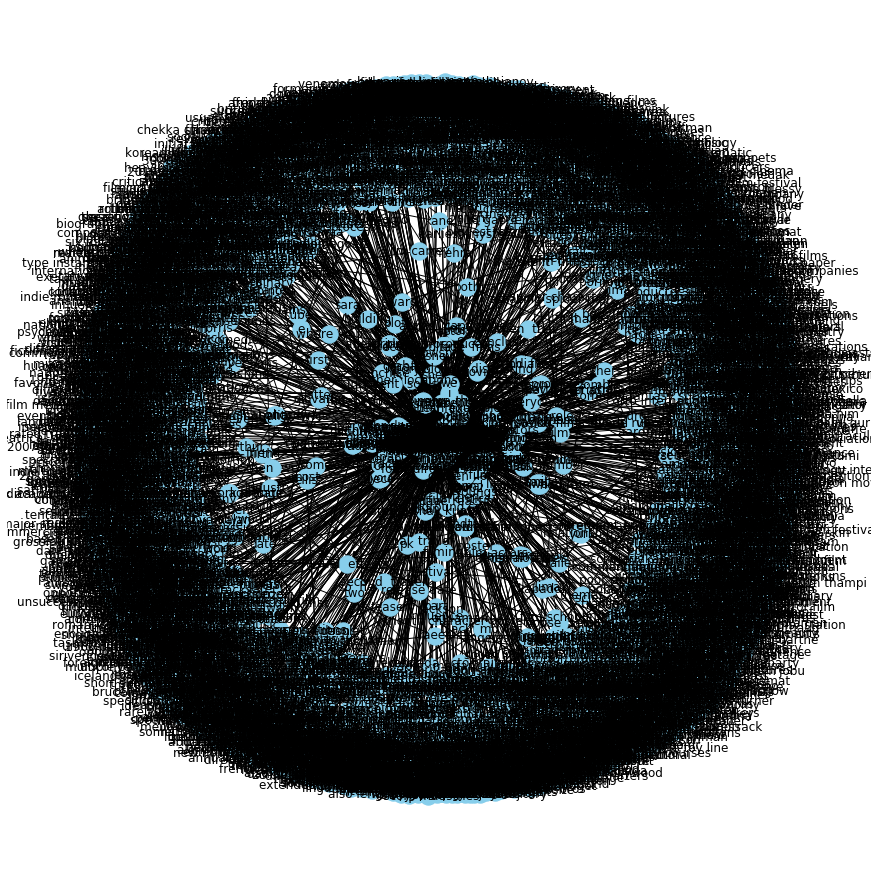

In [22]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, this is not exactly what we were hoping for (still looks quite a sight though!).

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use **only a few important relations to visualize a graph**. I will take one relation at a time. Let’s start with the relation “**composed by**”:



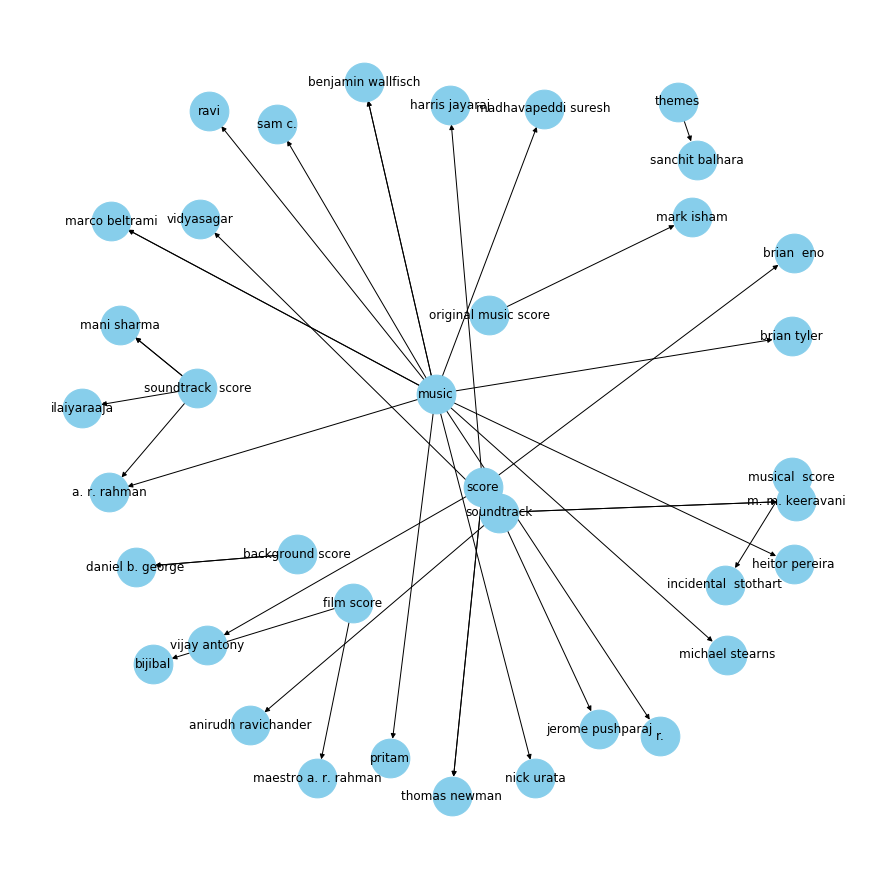

In [23]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph. Here the arrows point towards the composers. For instance, A.R. Rahman, who is a renowned music composer, has entities like “**soundtrack score**”, “**film score**”, and “**music**” connected to him in the graph above.

Let’s check out a few more relations.

Since writing is an important role in any movie, I would like to visualize the graph for the “**written by**” relation:

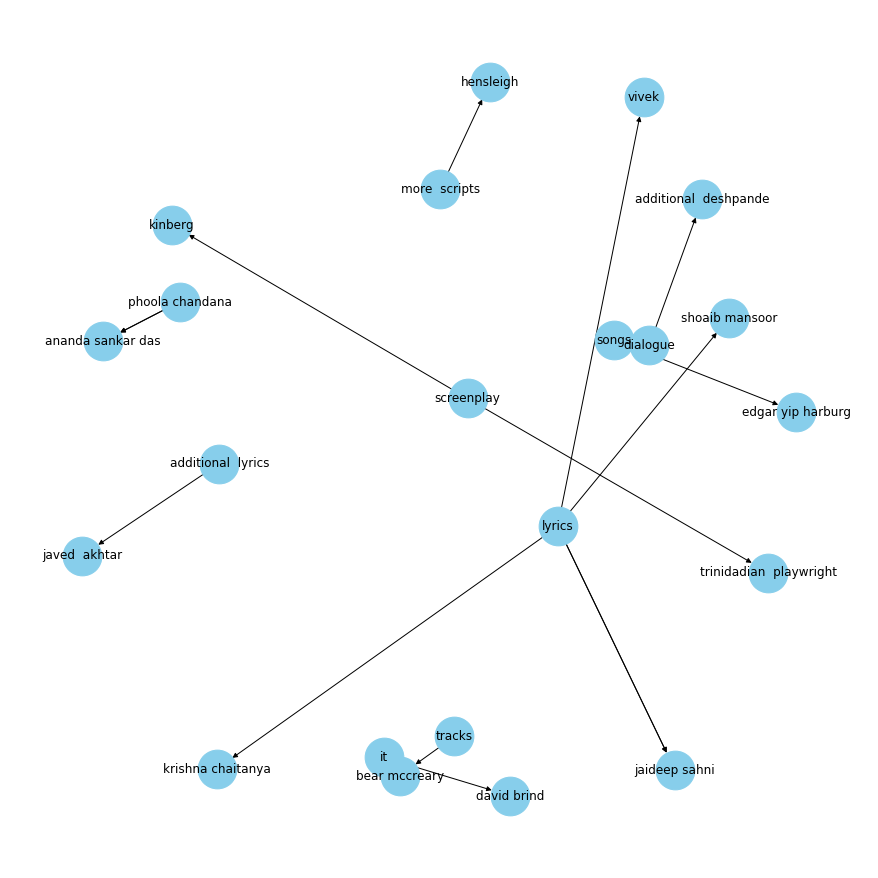

In [24]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Awesome! This knowledge graph is giving us some extraordinary information. Guys like **Javed Akhtar, Krishna Chaitanya, and Jaideep Sahni** are all famous lyricists and this graph beautifully captures this relationship.

Let’s see the knowledge graph of another important predicate, i.e., the “**released in**”:

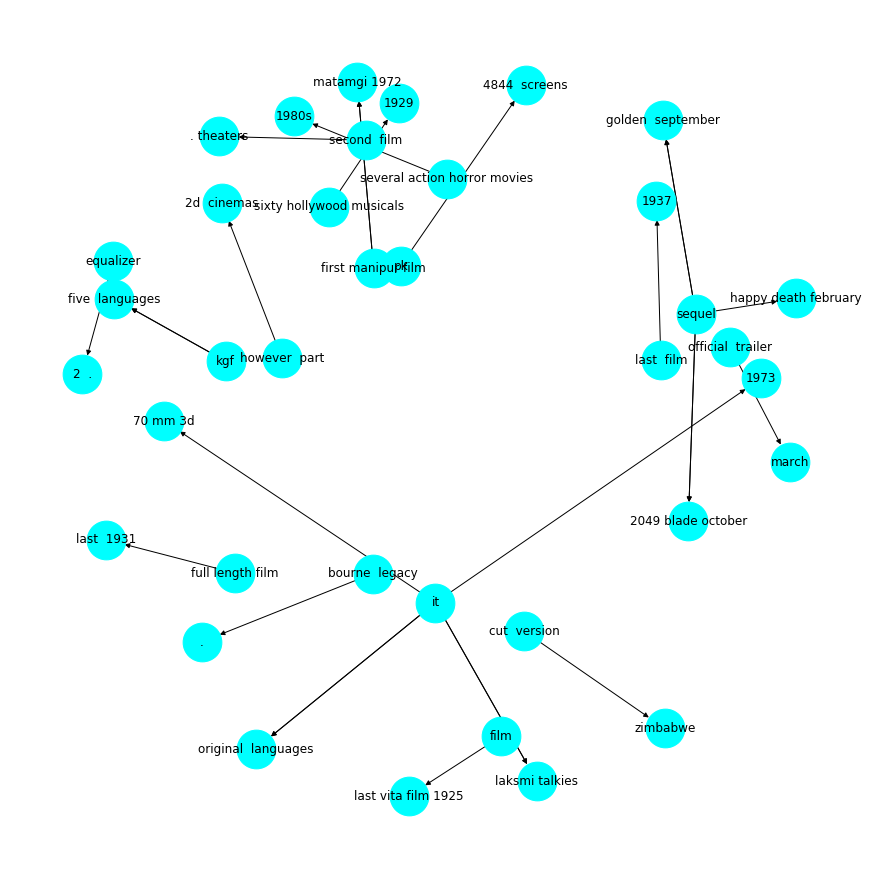

In [26]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='cyan', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

I can see quite a few interesting information in this graph. For example, look at this relationship – “several action horror movies released in the 1980s” and “pk released on 4844 screens”. These are facts and it shows us that we can mine such facts from just text. That’s quite amazing!